In [133]:
# Установим необходимые пакеты
!pip install catboost
!pip install graphviz
!pip install pydot
!pip install pyvis
!pip install pycairo
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install igraph

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [134]:
# Импортируем библиотеки
import catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploritary Data Analisys

In [155]:
# Прочитаем файлы
file_name = 'train.parquet'
df = pd.read_parquet(f'ke_test_data/{file_name}')

file_name = "categories_tree.csv"
category_tree = pd.read_csv(f'ke_test_data/{file_name}')

In [246]:
# Изучим данные на предмет пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283452 entries, 0 to 283451
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          283452 non-null  int64  
 1   title                       283452 non-null  object 
 2   short_description           283452 non-null  object 
 3   name_value_characteristics  283452 non-null  object 
 4   rating                      283452 non-null  float64
 5   feedback_quantity           283452 non-null  int64  
 6   category_id                 283452 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 15.1+ MB


#### Заполняем пропуски
Как видно в графе описания и характеристик присутствуют пропуски. Заполним их пустыми строками

In [247]:
df.short_description.fillna("", inplace=True);
df.name_value_characteristics.fillna("", inplace=True);

### Дизбаланс классов

In [248]:
# Всего 1231 конечных категорий. Но 280_000 товаров. Как они распределяются по категориям ?
n_category = len(df["category_id"].unique())
print(f"Число категорий: {n_category}")

Число категорий: 1231


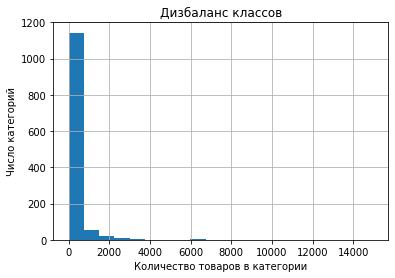

In [249]:
# Максимально неравномерно. Как видим на большую часть категорий приходиться только 500 товаров
# У меня как раз не хватает оперативной памяти для того, чтобы построить модель по всему датасету, 
# поэтому мы сократим его в 2-5 раз, и уравняем классы
df.groupby("category_id")["id"].count().hist(bins=20)
plt.title("Дизбаланс классов")
plt.xlabel("Количество товаров в категории")
plt.ylabel("Число категорий");

In [250]:
# Как видно, у половины категорий не более 60 товаров. Поэтому возьмём по 60 товаров (или меньше) с каждой
df.groupby("category_id")["id"].count().describe()

count     1231.000000
mean       230.261576
std        656.841724
min          2.000000
25%         17.000000
50%         60.000000
75%        200.000000
max      14967.000000
Name: id, dtype: float64

In [251]:
def take_n_samles(x):
    n = 60
    n_object_in_class = g.size()[x.category_id].iloc[0]
    
    if n > n_object_in_class:
        return x.sample(n_object_in_class).reset_index(drop=True)
    elif n <= n_object_in_class:
        return x.sample(n).reset_index(drop=True)

df_class_balanced = df.copy()  # Скопируем дф
g = df_class_balanced.groupby("category_id")  # Сгруппируем по категориям
df_balanced = g.apply(take_n_samles)  # Возьмём по 60 товаров в каждой категории, или меньше
df_balanced = df_balanced.reset_index(drop=True)  # Удалим индексы (они дублируют столбец категорий) 
    

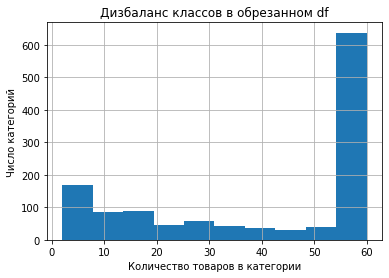

In [252]:
# Как видно ровно у половины категорий менее 60 товаров, а у другой половины, более
df_balanced.groupby("category_id")["id"].count().hist(bins=10)
plt.title("Дизбаланс классов в обрезанном df")
plt.xlabel("Количество товаров в категории")
plt.ylabel("Число категорий");

#### Тестовая и обучающая выборка
Поскольку присутсвует значительный дисбаланс классов, будем разбивать на тестовую и обучающую выборку внутри каждого класса.
Чтобы все классы присутсвовали в обоих выборках

In [253]:
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

# Если размер тестовой менее 50%, то в неё не попадёт категория с 2 товарами. Лучше написать свою функцию
train, test = train_test_split(df_balanced, test_size=0.5, stratify=df_balanced.category_id)  

# Проверим 
category_in_train = len(train.groupby("category_id")["id"].count())
category_in_test = len(test.groupby("category_id")["id"].count())
print(f"Число категорий в обучающей {category_in_train}, тестовой: {category_in_test}")

Число категорий в обучающей 1231, тестовой: 1231


## Baseline

Обучим модель на основе сбалансированного датасета.
Будем считать ее f1 score, как стартовую точку, для начала)

In [254]:
y_train = train["category_id"]
x_train = train.drop(columns=["id","category_id"])  # Удаляем id

test = df.drop(train.index)
y_test = test["category_id"]
x_test = test.drop(columns=["id","category_id"])

In [260]:
from catboost import Pool, CatBoostClassifier


text_features = [0, 1, 2]  # Название, описание, размеры


train_dataset = Pool(data=x_train,
                     label=y_train,            
                     text_features=text_features)

eval_dataset = Pool(data=x_test,
                    label=y_test,
                    text_features=text_features)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=2,
                           loss_function='MultiClass',
                           save_snapshot=True,
                           snapshot_file="snapshot2.bkp",
                           snapshot_interval=1,
                           random_seed=43,
                           custom_loss=["Accuracy"])  

In [261]:
# Fit model

model.fit(train_dataset,
          eval_set=eval_dataset,
          logging_level='Verbose',
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.0732188	test: 7.0586593	best: 7.0586593 (0)	total: 2m 12s	remaining: 3h 38m 50s
1:	learn: 7.0506771	test: 7.0250399	best: 7.0250399 (1)	total: 4m 38s	remaining: 3h 47m 8s
2:	learn: 7.0302659	test: 6.9946995	best: 6.9946995 (2)	total: 7m 2s	remaining: 3h 47m 28s
3:	learn: 7.0070696	test: 6.9607661	best: 6.9607661 (3)	total: 9m 25s	remaining: 3h 46m 23s
4:	learn: 6.9757357	test: 6.9253045	best: 6.9253045 (4)	total: 11m 51s	remaining: 3h 45m 27s
5:	learn: 6.9622406	test: 6.9041618	best: 6.9041618 (5)	total: 14m 17s	remaining: 3h 43m 53s
6:	learn: 6.9501408	test: 6.8852216	best: 6.8852216 (6)	total: 16m 41s	remaining: 3h 41m 45s
7:	learn: 6.9393131	test: 6.8683439	best: 6.8683439 (7)	total: 19m 6s	remaining: 3h 39m 42s
8:	learn: 6.9304692	test: 6.8530979	best: 6.8530979 (8)	total: 21m 30s	remaining: 3h 37m 26s
9:	learn: 6.9214793	test: 6.8390158	best: 6.8390158 (9)	total: 23m 54s	remaining: 3h 35m 9s
10:	learn: 6.9093401	test: 6.8257657	best: 6.8257657 (10)	total: 26m 18s	remai

86:	learn: 6.6427566	test: 6.5212052	best: 6.5212052 (86)	total: 3h 36m 22s	remaining: 32m 19s
87:	learn: 6.6409548	test: 6.5204950	best: 6.5204950 (87)	total: 3h 38m 47s	remaining: 29m 50s
88:	learn: 6.6373007	test: 6.5168714	best: 6.5168714 (88)	total: 3h 41m 27s	remaining: 27m 22s
89:	learn: 6.6362775	test: 6.5164645	best: 6.5164645 (89)	total: 3h 43m 52s	remaining: 24m 52s
90:	learn: 6.6349037	test: 6.5158193	best: 6.5158193 (90)	total: 3h 46m 31s	remaining: 22m 24s
91:	learn: 6.6335332	test: 6.5152031	best: 6.5152031 (91)	total: 3h 48m 55s	remaining: 19m 54s
92:	learn: 6.6317897	test: 6.5136041	best: 6.5136041 (92)	total: 3h 51m 20s	remaining: 17m 24s
93:	learn: 6.6297321	test: 6.5122301	best: 6.5122301 (93)	total: 3h 54m 2s	remaining: 14m 56s
94:	learn: 6.6284464	test: 6.5117890	best: 6.5117890 (94)	total: 3h 56m 26s	remaining: 12m 26s
95:	learn: 6.6262406	test: 6.5099188	best: 6.5099188 (95)	total: 3h 58m 51s	remaining: 9m 57s
96:	learn: 6.6238775	test: 6.5087239	best: 6.5087239

In [262]:
# Сохраним модель
file_name = "model_base_with_balance_50to50"
model.save_model(fname=f'ke_test_data/{file_name}',
                 format="cbm",
                )

In [263]:
# Посмотрим предсказания на тесте
preds_class = model.predict(eval_dataset) # Предскажем тестового датасета

In [393]:
# Ожидаемо, самым полезным оказалось название и описание
model.get_feature_importance(prettified=True)

In [368]:
from sklearn.metrics import accuracy_score, f1_score

print(f'Simple model validation accuracy: {accuracy_score(y_test, preds_class)}')
aver = 'weighted'
print(f'f1_score for predicted: {f1_score(y_test, preds_class, average=aver)}')

Simple model validation accuracy: 0.5470354717088711
f1_score for predicted: 0.49211736299909414


Качество очень низкое. Нужно повышать его:


 1) Создать граф моделей, где для каждой категории будем предсказывать подкатегории и далее

 2) Улучшить распознавания текста, создав эмбрендинги на другой модели (например BERT)
 
 3) 80% товаров приходится на 10% категорий. Мы можем хорошо научиться определять их
 
 Таким образом запустим модель на обучение по всей всему датасету, если результаты окажутся неудолетворительными, добавить модель трансформера

## Работа с графами
Задача: Написать функцию для возврата родителя для каждого товара, чтобы посчитать f1 для всех уровней

### Постоение графа

In [144]:
import networkx as nx
from pyvis.network import Network
import graphviz
import pydot

In [159]:
parentid_id = pd.concat([category_tree["parent_id"],category_tree["id"]],axis=1) # Выбираем строки для создания графа
parentid_id = parentid_id.to_numpy() # Граф работает через numpy
info = category_tree["title"] 
category_tree = category_tree.set_index("id")

In [160]:
G = nx.DiGraph()
G.add_edges_from(parentid_id)
miss_id = [0, 2779, 10017]  # Данные id не существуют, но указаны как parent_id
for node_id in G.nodes: # Дадим названия каждому элементу графа
    G.nodes[node_id]["title"] = category_tree.loc[node_id]["title"]

In [161]:
print(f"number_of_nodes: {G.number_of_nodes()}") # Выведем характеристики графа
print(f"number_of_edges: {G.number_of_edges()}")

number_of_nodes: 3373
number_of_edges: 3373


In [237]:
# Визуализация графа (много весит, подлагивает)
import pydot
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.pyplot import figure

# figure(figsize=(30, 20), dpi=800)
# pos = graphviz_layout(G, prog="dot")
# nx.draw(G, pos)
# plt.show()

![alt text](Graph_image.png "Title")

### Поиск родителей для каждого элемента

In [322]:
def parent(id_n,level=1):
    if isinstance(id_n, np.ndarray): 
        if np.ndim(id_n) == 2: id_n = np.squeeze(id_n)
        id_n = id_n.tolist()
        
    level_all = []
    for id in id_n:
        if level == 1:
            level_1 = [i for i in G.predecessors(id)]
            level_last = level_1[0]

        elif level == 2:
            level_1 = [i for i in G.predecessors(id)]
            level_2 = [i for i in G.predecessors(level_1[0])]
            level_1.append(level_2[0])
            level_last = level_2[0]


        elif level == 3:
            level_1 = [i for i in G.predecessors(id)]
            level_2 = [i for i in G.predecessors(level_1[0])]
            level_1.append(level_2[0])
            level_3 = [i for i in G.predecessors(level_2[0])]
            level_1.append(level_3[0])
            level_last = level_3[0]
            
            
        level_all.append(level_last)
        
    return level_all
    
print(parent(id_n=[114, 1913, 1821, 1],level=1))

[1913, 1821, 1, 0]


In [199]:
# Данные id идут от 0, хотя должны от 1 ("Все категории")
descendants_0 = nx.descendants(G,0)
descendants_1 = nx.descendants(G,1)

for des_0 in descendants_0:
    if not des_0 in descendants_1: 
        print(f"{des_0} not in 1 graph")

1 not in 1 graph
553 not in 1 graph
1754 not in 1 graph
2000 not in 1 graph
2779 not in 1 graph
2780 not in 1 graph
2781 not in 1 graph
2782 not in 1 graph
2783 not in 1 graph
2784 not in 1 graph
2785 not in 1 graph
2786 not in 1 graph
2787 not in 1 graph
2788 not in 1 graph
2789 not in 1 graph
2790 not in 1 graph
2791 not in 1 graph
2792 not in 1 graph
2793 not in 1 graph
2794 not in 1 graph
2795 not in 1 graph
2796 not in 1 graph
2890 not in 1 graph


### Насколько базовая модель точно определяет родителей ?
Всё-же точность весьма низкая. А значит, что натренировав несколько моделей, мы можем улучшить результаты

In [345]:
# Точность для уровня 1 :
y_test_level1 = parent(id_n=y_test, level=1)
preds_class_level1 = parent(id_n=preds_class, level=1)
print(f'Simple accuracy for parents level_1: {accuracy_score(y_test_level1, preds_class_level1)}')

# Точность для уровня 2 :
y_test_level2 = parent(id_n=y_test_level1, level=1)
preds_class_level2 = parent(id_n=preds_class_level1, level=1)
print(f'Simple accuracy for parents level_2: {accuracy_score(y_test_level2, preds_class_level2)}')

# Точность для уровня 3 :
y_test_level3 = parent(id_n=y_test_level2, level=1)
preds_class_level3 = parent(id_n=preds_class_level2, level=1)
print(f'Simple accuracy for parents level_3: {accuracy_score(y_test_level3, preds_class_level3)}')

# Точность для уровня 4 :
y_test_level4 = parent(id_n=y_test_level3, level=1)
preds_class_level4 = parent(id_n=preds_class_level3, level=1)
print(f'Simple accuracy for parents level_4: {accuracy_score(y_test_level4, preds_class_level4)}')

# Точность для уровня 5 :
y_test_level5 = parent(id_n=y_test_level4, level=1)
preds_class_level5 = parent(id_n=preds_class_level4, level=1)
print(f'Simple accuracy for parents level_5: {accuracy_score(y_test_level5, preds_class_level5)}')


Simple accuracy for parents level_1: 0.08480583144072026
Simple accuracy for parents level_2: 0.1501890033699475
Simple accuracy for parents level_3: 0.322787577236024
Simple accuracy for parents level_4: 0.7550810373712088
Simple accuracy for parents level_5: 0.9599243212709074


А какая будет точность на несбалансированной выборке ?

## Catboost на полном датасете

In [355]:
# Разделим датасет равномерно по категориям. Ровно поплам, поскольку есть категория с 2 товарами
train, test = train_test_split(df, test_size=0.5, stratify=df.category_id)

y_train = train["category_id"]
x_train = train.drop(columns=["id","category_id"])  # Удаляем id

test = df.drop(train.index)
y_test = test["category_id"]
x_test = test.drop(columns=["id","category_id"])

In [358]:
from catboost import Pool, CatBoostClassifier


text_features = [0, 1, 2]  # Название, описание, размеры


train_dataset = Pool(data=x_train,
                     label=y_train,            
                     text_features=text_features)

eval_dataset = Pool(data=x_test,
                    label=y_test,
                    text_features=text_features)

# Initialize CatBoostClassifier
model_full = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=2,
                           loss_function='MultiClass',
                           save_snapshot=True,
                           snapshot_file="snapshot_full.bkp",
                           snapshot_interval=1,
                           random_seed=43,
                               )  

In [359]:
# Fit model#

model_full.fit(train_dataset,
          eval_set=eval_dataset,
          logging_level='Verbose',
          plot=True
          )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6.6927011	test: 6.3770699	best: 6.3770699 (0)	total: 12m 14s	remaining: 20h 11m 49s
1:	learn: 6.3957210	test: 6.0729483	best: 6.0729483 (1)	total: 25m 52s	remaining: 21h 7m 49s
2:	learn: 6.2380453	test: 5.9185265	best: 5.9185265 (2)	total: 39m 42s	remaining: 21h 23m 42s
3:	learn: 6.0479989	test: 5.7825221	best: 5.7825221 (3)	total: 53m 28s	remaining: 21h 23m 30s
4:	learn: 5.7795070	test: 5.6392290	best: 5.6392290 (4)	total: 1h 7m 29s	remaining: 21h 22m 22s
5:	learn: 5.9058950	test: 5.8628428	best: 5.6392290 (4)	total: 1h 21m 31s	remaining: 21h 17m 15s
6:	learn: 5.6073386	test: 5.5188295	best: 5.5188295 (6)	total: 1h 35m 16s	remaining: 21h 5m 46s
7:	learn: 5.5076378	test: 5.4224509	best: 5.4224509 (7)	total: 1h 48m 50s	remaining: 20h 51m 40s
8:	learn: 5.4221478	test: 5.3316014	best: 5.3316014 (8)	total: 2h 2m 18s	remaining: 20h 36m 43s
9:	learn: 5.3517759	test: 5.2603711	best: 5.2603711 (9)	total: 2h 15m 52s	remaining: 20h 22m 50s
10:	learn: 5.2488823	test: 5.1583294	best: 5.1

84:	learn: 3.6674260	test: 3.4573143	best: 3.4573143 (84)	total: 20h 3m 36s	remaining: 3h 32m 24s
85:	learn: 3.6633026	test: 3.4529799	best: 3.4529799 (85)	total: 20h 19m 8s	remaining: 3h 18m 27s
86:	learn: 3.6564181	test: 3.4457548	best: 3.4457548 (86)	total: 20h 35m 13s	remaining: 3h 4m 34s
87:	learn: 3.6531193	test: 3.4423736	best: 3.4423736 (87)	total: 20h 51m 16s	remaining: 2h 50m 37s
88:	learn: 3.6422767	test: 3.4321151	best: 3.4321151 (88)	total: 21h 8m 3s	remaining: 2h 36m 43s
89:	learn: 3.6380717	test: 3.4273668	best: 3.4273668 (89)	total: 21h 23m 35s	remaining: 2h 22m 37s
90:	learn: 3.6308498	test: 3.4195507	best: 3.4195507 (90)	total: 21h 39m 4s	remaining: 2h 8m 28s
91:	learn: 3.6269151	test: 3.4160500	best: 3.4160500 (91)	total: 21h 54m 25s	remaining: 1h 54m 17s
92:	learn: 3.6231031	test: 3.4122716	best: 3.4122716 (92)	total: 22h 10m 20s	remaining: 1h 40m 8s
93:	learn: 3.6220549	test: 3.4112417	best: 3.4112417 (93)	total: 22h 26m 20s	remaining: 1h 25m 56s
94:	learn: 3.61801

Обучение заняло сутки, но результаты весьма хороши. Большее кол-во данных благоприятно влияет на модель
Посмотрим, какая фича оказалась наиболее полезной ?

In [361]:
# Сохраним модель на всякий случай
file_name = "model_cat_full_data"
model_full.save_model(fname=f'ke_test_data/{file_name}',
                 format="cbm",)

In [394]:
# Самым полезным оказалось название, все остальное было проигнорировано. Значит другая модель обработки естественного языка тут будет кстати
model_full.get_feature_importance(prettified=True)

,Feature Id,Importances
0,title,100.0
1,short_description,0.0
2,name_value_characteristics,0.0
3,rating,0.0
4,feedback_quantity,0.0


In [363]:
# Расчитаем метрику на всём датасете
train, test = train_test_split(df, test_size=0.99) 

y_test = test["category_id"]
x_test = test.drop(columns=["id","category_id"])

text_features = [0, 1, 2]  # Название, описание, размеры
eval_dataset = Pool(data=x_test,
                    label=y_test,
                    text_features=text_features)

preds_class = model_full.predict(eval_dataset) # Предскажем тестового датасета

In [367]:
# f1 calculate для решения и родителей
from sklearn.metrics import f1_score

aver = 'weighted'
print(f'f1_score for predicted: {f1_score(y_test, preds_class, average=aver)}')

# Точность для уровня 1 :
y_test_level1 = parent(id_n=y_test, level=1)
preds_class_level1 = parent(id_n=preds_class, level=1)
print(f'f1_score for parents level_1: {f1_score(y_test_level1, preds_class_level1, average=aver)}')

# Точность для уровня 2 :
y_test_level2 = parent(id_n=y_test_level1, level=1)
preds_class_level2 = parent(id_n=preds_class_level1, level=1)
print(f'f1_score for parents level_2: {f1_score(y_test_level2, preds_class_level2, average=aver)}')

# Точность для уровня 3 :
y_test_level3 = parent(id_n=y_test_level2, level=1)
preds_class_level3 = parent(id_n=preds_class_level2, level=1)
print(f'f1_score for parents level_3: {f1_score(y_test_level3, preds_class_level3, average=aver)}')

# Точность для уровня 4 :
y_test_level4 = parent(id_n=y_test_level3, level=1)
preds_class_level4 = parent(id_n=preds_class_level3, level=1)
print(f'f1_score for parents level_4: {f1_score(y_test_level4, preds_class_level4, average=aver)}')

# Точность для уровня 5 :
y_test_level5 = parent(id_n=y_test_level4, level=1)
preds_class_level5 = parent(id_n=preds_class_level4, level=1)
print(f'f1_score for parents level_5: {f1_score(y_test_level5, preds_class_level5, average=aver)}')

f1_score for predicted: 0.49211736299909414
f1_score for parents level_1: 0.5627870865539822
f1_score for parents level_2: 0.6204780768617958
f1_score for parents level_3: 0.7198579376470868
f1_score for parents level_4: 0.8875820245256695
f1_score for parents level_5: 0.9827886054497198


# Записываем ответы

In [373]:
# Посмотрим проверочный датасет
file_name = 'test.parquet'
df_test = pd.read_parquet(f'ke_test_data/{file_name}')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          70864 non-null  int64  
 1   title                       70864 non-null  object 
 2   short_description           33346 non-null  object 
 3   name_value_characteristics  12576 non-null  object 
 4   rating                      70864 non-null  float64
 5   feedback_quantity           70864 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.2+ MB


In [375]:
# Заполним пропуски
df_test.short_description.fillna("", inplace=True);
df_test.name_value_characteristics.fillna("", inplace=True);

# Предскажем значения
x_test = df_test.drop(columns=["id"])

text_features = [0, 1, 2]  # Название, описание, размеры
eval_dataset = Pool(data=x_test,
                    text_features=text_features)

preds_test_class = model_full.predict(eval_dataset) # Предскажем проверочного датасета

In [389]:
preds_test_class = np.squeeze(preds_test_class) # Понизим размерность ответов с 2 до 1 
d = {'id': df_test.id, 'predicted_category_id': preds_test_class}
df_test_answered = pd.DataFrame(data=d) # Запишим в датасет ответы
df_test_answered.head()

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,2803
3,1577569,13061
4,869328,13061


In [397]:
# Запишем ответы в файл
file_name = "result.parquet"
df_test_answered.to_parquet(f'ke_test_data/{file_name}') 

In [398]:
try_test = pd.read_parquet(f'ke_test_data/{file_name}')
try_test.head()

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,2803
3,1577569,13061
4,869328,13061
